In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel

from importlib import reload
reload(chipmultilabel)

<module 'earthtext.datamodules.chipmultilabel' from '/home/ubuntu/projects/earth-text/src/earthtext/datamodules/chipmultilabel.py'>

In [2]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-24 16:19:07.336 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-24 16:19:10.641 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read train split with 58599 chip files (out of 58690)
2024-04-24 16:19:10.642 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-24 16:19:11.014 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-24 16:19:11.676 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read val split with 11822 chip files (out of 11841)
2024-04-24 16:19:11.676 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-

In [3]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

570723

In [41]:
n_epochs = 100

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel']

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 3662 loss 0.18107 params 0.0372505
epoch   1 step 3662 loss 0.16092 params 0.0548792
epoch   2 step 3662 loss 0.16104 params 0.0787925
epoch   3 step 3662 loss 0.15156 params 0.1040352
epoch   4 step 3662 loss 0.15418 params 0.1296543
epoch   5 step 3662 loss 0.15132 params 0.1555556
epoch   6 step 3662 loss 0.14828 params 0.1809191
epoch   7 step 3662 loss 0.14441 params 0.2062438
epoch   8 step 3662 loss 0.14654 params 0.2316728
epoch   9 step 3662 loss 0.13655 params 0.2574063
epoch  10 step 3662 loss 0.13560 params 0.2832924
epoch  11 step 3662 loss 0.13956 params 0.3092105
epoch  12 step 3662 loss 0.13672 params 0.3350891
epoch  13 step 3662 loss 0.13945 params 0.3614272
epoch  14 step 3662 loss 0.13764 params 0.3881465
epoch  15 step 3662 loss 0.13452 params 0.4148999
epoch  16 step 3662 loss 0.14010 params 0.4415251
epoch  17 step 3662 loss 0.13182 params 0.4681677
epoch  18 step 3662 loss 0.14323 params 0.4946820
epoch  19 step 3662 loss 0.13746 params 0.5210291


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

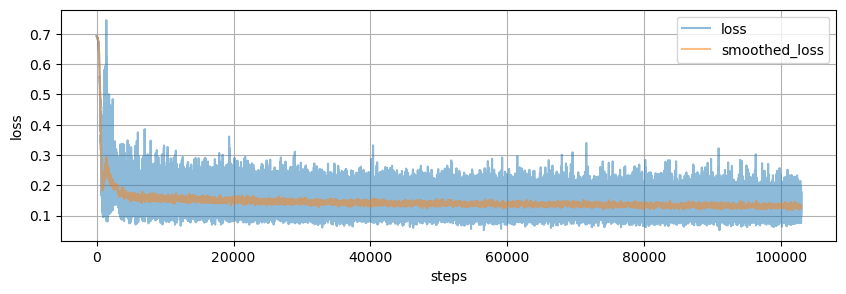

In [42]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")

In [43]:
targets = []
predictions = []
dltrain = dl.train_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel']

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (3663 of 3663) |####################| Elapsed Time: 0:00:12 Time:  0:00:120001


((58599, 99), (58599, 99))

In [44]:
idxs = np.random.permutation(len(targets))[:300]

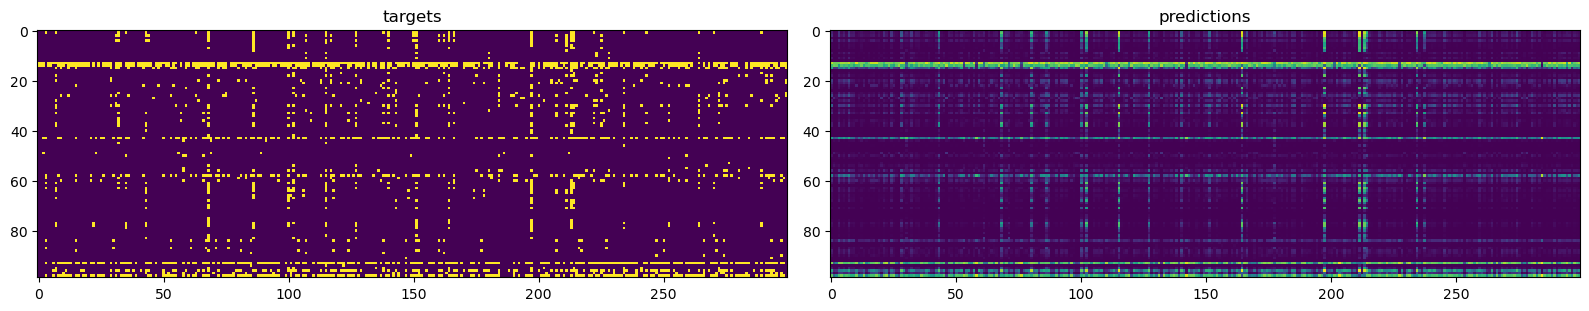

In [45]:
for ax, i in subplots(2, usizex=8):
    if i==0: 
        plt.imshow(targets[idxs].T, interpolation='none')
        plt.title("targets")
    if i==1:
        plt.imshow(predictions[idxs].T, interpolation='none', vmin=0, vmax=1)
        plt.title("predictions")
        #plt.colorbar();

In [13]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
tnr = lambda y_true, y_pred: np.mean(y_true[y_true==0] == y_pred[y_true==0])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None

acc = lambda y_true, y_pred: np.mean(y_true==y_pred)
# 'tpr': 0.5767012011351924,
#  'tnr': 0.9821519242111034,
#  'acc': 0.9543408209300903,
#  'prec': 0.7041051529853083
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred), 'tnr': tnr(y_true, y_pred), 'acc': acc(y_true, y_pred), 'prec': prec(y_true, y_pred)}

In [64]:
metr(targets.flatten(), predictions.flatten()>.5)

{'tpr': 0.5276476879276076,
 'tnr': 0.9838512692064086,
 'acc': 0.9516453292114992,
 'prec': 0.7127976092305865}

In [13]:
precision_score(targets.flatten(), predictions.flatten()>.5), \
recall_score(targets.flatten(), predictions.flatten()>.5)


(0.7041051529853083, 0.5767012011351924)

In [66]:
r = [metr(targets[:,c], predictions[:,c]>.5) for c in range(targets.shape[-1])]    
r = pd.DataFrame(r)

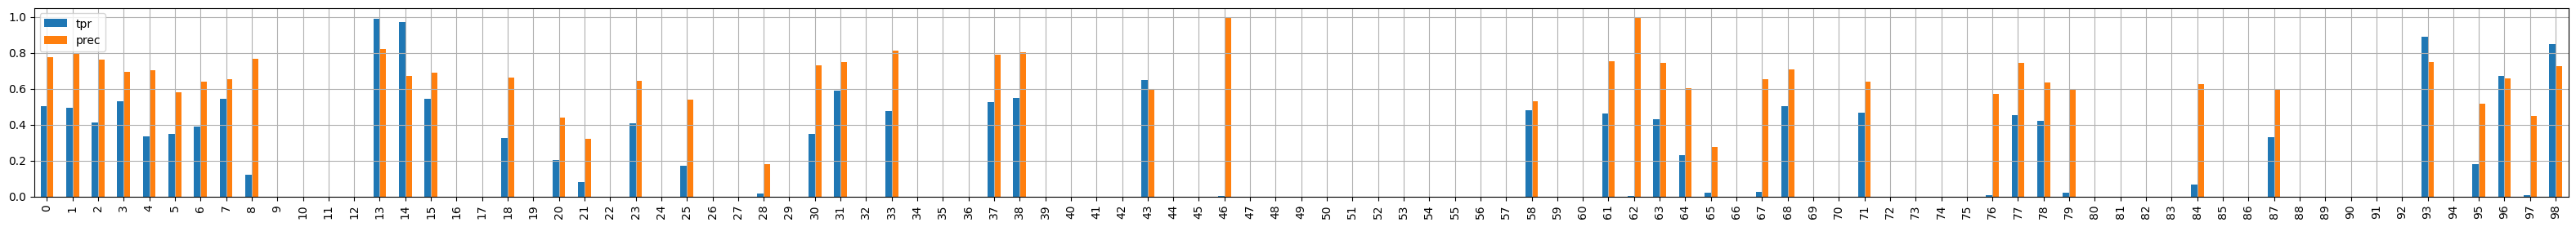

In [15]:
r[['tpr', 'prec']].plot(kind='bar', figsize=(40,3))
plt.grid()

Classes to discard due to recall < .1 :
- 9, 10, 11, 12, 16, 17, 19, 21, 22, 24, 26, 27, 28, 29, 32, 34, 35, 36, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 62, 65, 66, 67, 69, 70, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 94, 97

Classes to retain :
- 0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 18, 20, 23, 25, 30, 31, 33, 37, 38, 43, 58, 61, 63, 64, 68, 71, 77, 78, 87, 93, 95, 96, 98

Difficulty 1 (R,P > .7)
- 13, 14, 93, 98

Difficulty 2 (0.5 <= R <= .7, P >= .7)
- 0, 1, 3, 15, 31, 33, 37, 38, 68, 77

Difficulty 3 (0.1 <= R < .5, P >= .6)
- 2, 4, 8, 18, 30, 61, 63, 71, 78, 87, 96

Difficulty 4 (0.1 <= R < .5, P < .6)
- 5, 6, 7, 20, 23, 25, 43, 58, 64, 95

In [13]:
classes_retain = [0, 1, 2, 3, 4, 5, 6, 7, 8, 13,
                  14, 15, 18, 20, 23, 25, 30, 31, 33, 37,
                  38, 43, 58, 61, 63, 64, 68, 71, 77, 78,
                  87, 93, 95, 96, 98]
classes_difficulty_1 = [13, 14, 93, 98]
classes_difficulty_2 = [0, 1, 3, 15, 31, 33, 37, 38, 68, 77]
classes_difficulty_3 = [2, 4, 8, 18, 30, 61, 63, 71, 78, 87, 96]
classes_difficulty_4 = [5, 6, 7, 20, 23, 25, 43, 58, 64, 95]

In [14]:
from earthtext.osm import multilabel
name_dict = multilabel.kvmerged.inverse_codes

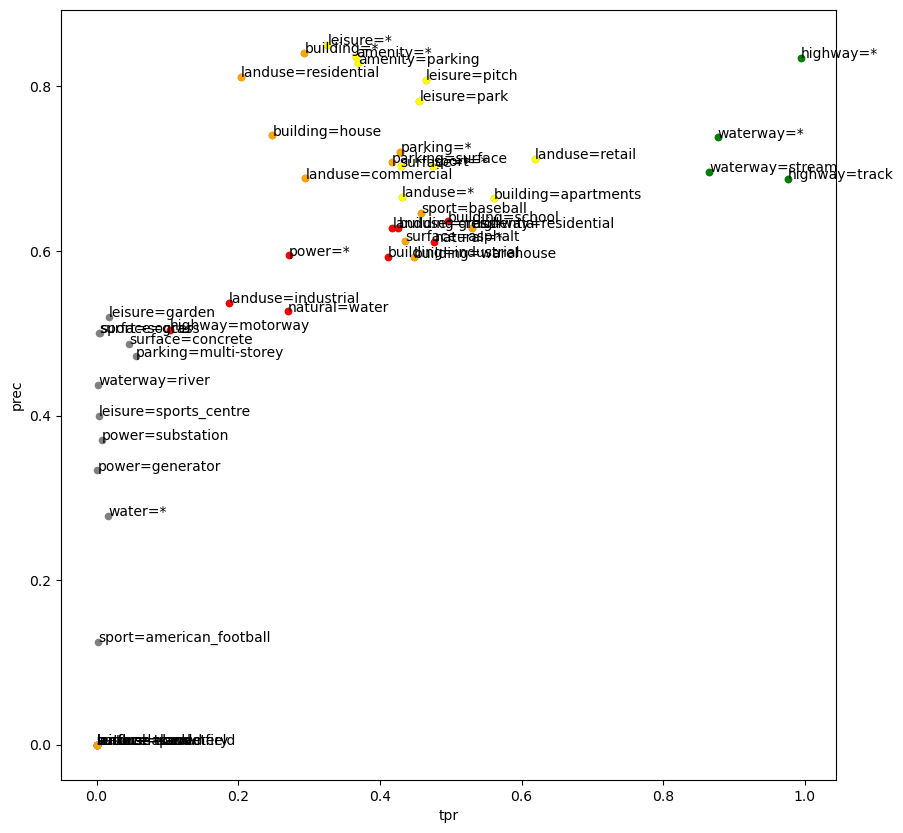

In [166]:
ax = r[['tpr', 'prec']].plot(kind='scatter', x='tpr', y='prec', c='gray', figsize=(10,10))
r[['tpr', 'prec']].loc[classes_difficulty_4].plot(kind='scatter', x='tpr', y='prec', c='red', ax=ax)
r[['tpr', 'prec']].loc[classes_difficulty_3].plot(kind='scatter', x='tpr', y='prec', c='orange', ax=ax)
r[['tpr', 'prec']].loc[classes_difficulty_2].plot(kind='scatter', x='tpr', y='prec', c='yellow', ax=ax)
r[['tpr', 'prec']].loc[classes_difficulty_1].plot(kind='scatter', x='tpr', y='prec', c='green', ax=ax);

for i in range(len(np.array(r.tpr))):
    if not np.isnan(np.array(r.prec)[i]):
        # print(np.array(r.tpr)[i], np.array(r.prec)[i])
        # ax.text(x=np.array(r.tpr)[i], y=np.array(r.prec)[i], s=list(r.index)[i])
        ax.text(x=np.array(r.tpr)[i], y=np.array(r.prec)[i], s=name_dict[list(r.index)[i]], size=10)

# Retrain again only on retained classes

We can also remove the following
- `amenity=*`, 0
- `building=warehouse`, 8
- `highway=*`, 13
- `landuse=*`, 15
- `landuse=residential`, 30

In [12]:
# classes_retain = [1, 2, 3, 4, 5, 6, 7, 14, 18, 20, 23, 25, 31, 33, 37,
#                   38, 43, 58, 61, 63, 64, 68, 71, 77, 78, 87, 93, 95, 96, 98]

classes_retain = [0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 18, 20, 23, 25, 30, 31, 33, 37,
                  38, 43, 58, 61, 63, 64, 68, 71, 77, 78, 87, 93, 95, 96, 98]

In [17]:
conf = OmegaConf.load("../../configs/multilabel.yaml")
conf.dataloader.batch_size = 32
conf.model.output_dim = len(classes_retain)
# conf.model.dropout = True
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-24 16:49:30.730 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for train split
100% (58690 of 58690) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-24 16:49:34.116 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read train split with 58599 chip files (out of 58690)
2024-04-24 16:49:34.117 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-24 16:49:34.490 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for val split
100% (11841 of 11841) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-24 16:49:35.169 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read val split with 11822 chip files (out of 11841)
2024-04-24 16:49:35.170 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-

In [18]:
dltrain = dl.train_dataloader()
m = hydra.utils.instantiate(conf.model)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
sum([np.product(p.shape) for p in m.parameters()])

562467

In [19]:
n_epochs = 200

lossh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        x = batch['embedding']
        t = batch['multilabel'][:, classes_retain]

        # run model
        o = m(x)

        # compute losses (complex mse or rmse)
        loss = - torch.mean(torch.log(o + 1e-5)*t + torch.log(1-o + 1e-5)*(1-t))
        
        # backpropage and update
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        lossh.append(lossn)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-50:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f}", end="\r")
        
    print()

epoch   0 step 1831 loss 0.32455 params 0.0311651
epoch   1 step 1831 loss 0.30547 params 0.0359821
epoch   2 step 1831 loss 0.28133 params 0.0435798
epoch   3 step 1831 loss 0.28027 params 0.0527792
epoch   4 step 1831 loss 0.27158 params 0.0626391
epoch   5 step 1831 loss 0.28296 params 0.0729821
epoch   6 step 1831 loss 0.28026 params 0.0837470
epoch   7 step 1831 loss 0.26919 params 0.0949285
epoch   8 step 1831 loss 0.26992 params 0.1066191
epoch   9 step 1831 loss 0.26720 params 0.1185568
epoch  10 step 1831 loss 0.26110 params 0.1305814
epoch  11 step 1831 loss 0.26905 params 0.1427284
epoch  12 step 1831 loss 0.26190 params 0.1550041
epoch  13 step 1831 loss 0.25930 params 0.1673404
epoch  14 step 1831 loss 0.25535 params 0.1795354
epoch  15 step 1831 loss 0.24783 params 0.1918128
epoch  16 step 1831 loss 0.25666 params 0.2040475
epoch  17 step 1831 loss 0.26252 params 0.2160994
epoch  18 step 1831 loss 0.25087 params 0.2281088
epoch  19 step 1831 loss 0.25166 params 0.2398898


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



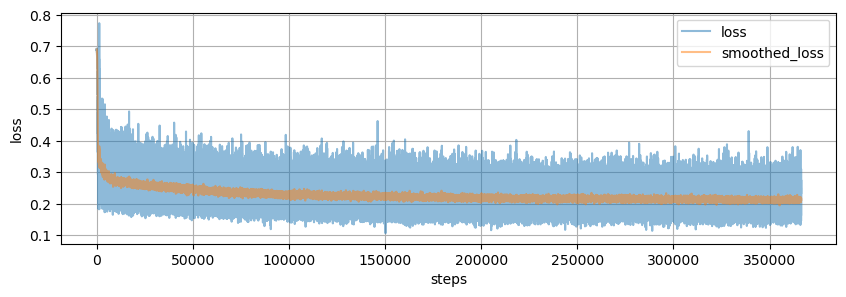

In [20]:
lossp = pd.DataFrame(lossh, columns=['loss'])
lossp['smoothed_loss'] = lossp.loss.rolling(50).mean()
lossp.plot(alpha=.5, figsize=(10,3))
plt.grid(); plt.xlabel("steps"); plt.ylabel("loss");

In [81]:
targets = []
predictions = []
# dltrain = dl.train_dataloader()
dltrain = dl.test_dataloader()
for batch in pbar(dltrain):
    x = batch['embedding']
    t = batch['multilabel'][:, classes_retain]

    o = m(x)

    for ti in t.detach().numpy():
        targets.append(ti)

    for oi in o.detach().numpy():
        predictions.append(oi)
    
targets = np.r_[targets]
predictions = np.r_[predictions]
targets.shape, predictions.shape

100% (409 of 409) |######################| Elapsed Time: 0:00:03 Time:  0:00:030000


((13071, 35), (13071, 35))

In [82]:
idxs = np.random.permutation(len(targets))[:300]

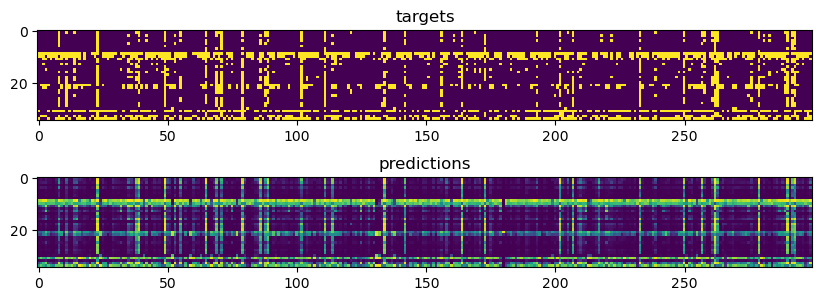

In [83]:
fig, ax = plt.subplots(2, 1, figsize=(10,3.5));
ax[0].imshow(targets[idxs].T, interpolation='none');
ax[0].set_title("targets");
ax[1].imshow(predictions[idxs].T, interpolation='none');
ax[1].set_title("predictions");
# fig.tight_layout()

In [90]:
from sklearn.metrics import precision_score, recall_score

tpr = lambda y_true, y_pred: np.mean(y_true[y_true==1] == y_pred[y_true==1])
prec = lambda y_true, y_pred: sum(y_true[y_pred==1]) / sum(y_pred==1) if sum(y_pred==1)>0 else None
# tnr = lambda y_true, y_pred: np.mean(y_true[y_true==0] == y_pred[y_true==0])
# acc = lambda y_true, y_pred: np.mean(y_true==y_pred)
metr = lambda y_true, y_pred: {'tpr': tpr(y_true, y_pred), 'prec': prec(y_true, y_pred)}

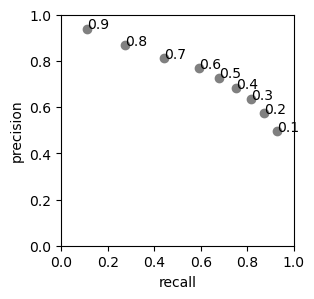

In [85]:
fig = plt.figure(figsize=(3, 3))
for thres in np.arange(.1, 1, .1):
    _rp = metr(targets.flatten(), predictions.flatten()>thres)
    _rec = _rp['tpr']
    _prec = _rp['prec']
    plt.scatter(_rec, _prec, c='gray');
    plt.text(_rec, _prec, round(thres, 1));
plt.xlabel("recall"); plt.ylabel("precision"); plt.xlim(0,1); plt.ylim(0,1);

In [118]:
R = []
for thres in np.linspace(0.1, 1, 10):
    r = [metr(targets[:,c], predictions[:,c] >= thres) for c in range(targets.shape[-1])]    
    r = pd.DataFrame(r)
    R.append(r)

R = np.array([r.values for r in R])
R.shape

(10, 35, 2)

---

In [29]:
from earthtext.osm import multilabel
name_dict = multilabel.kvmerged.inverse_codes

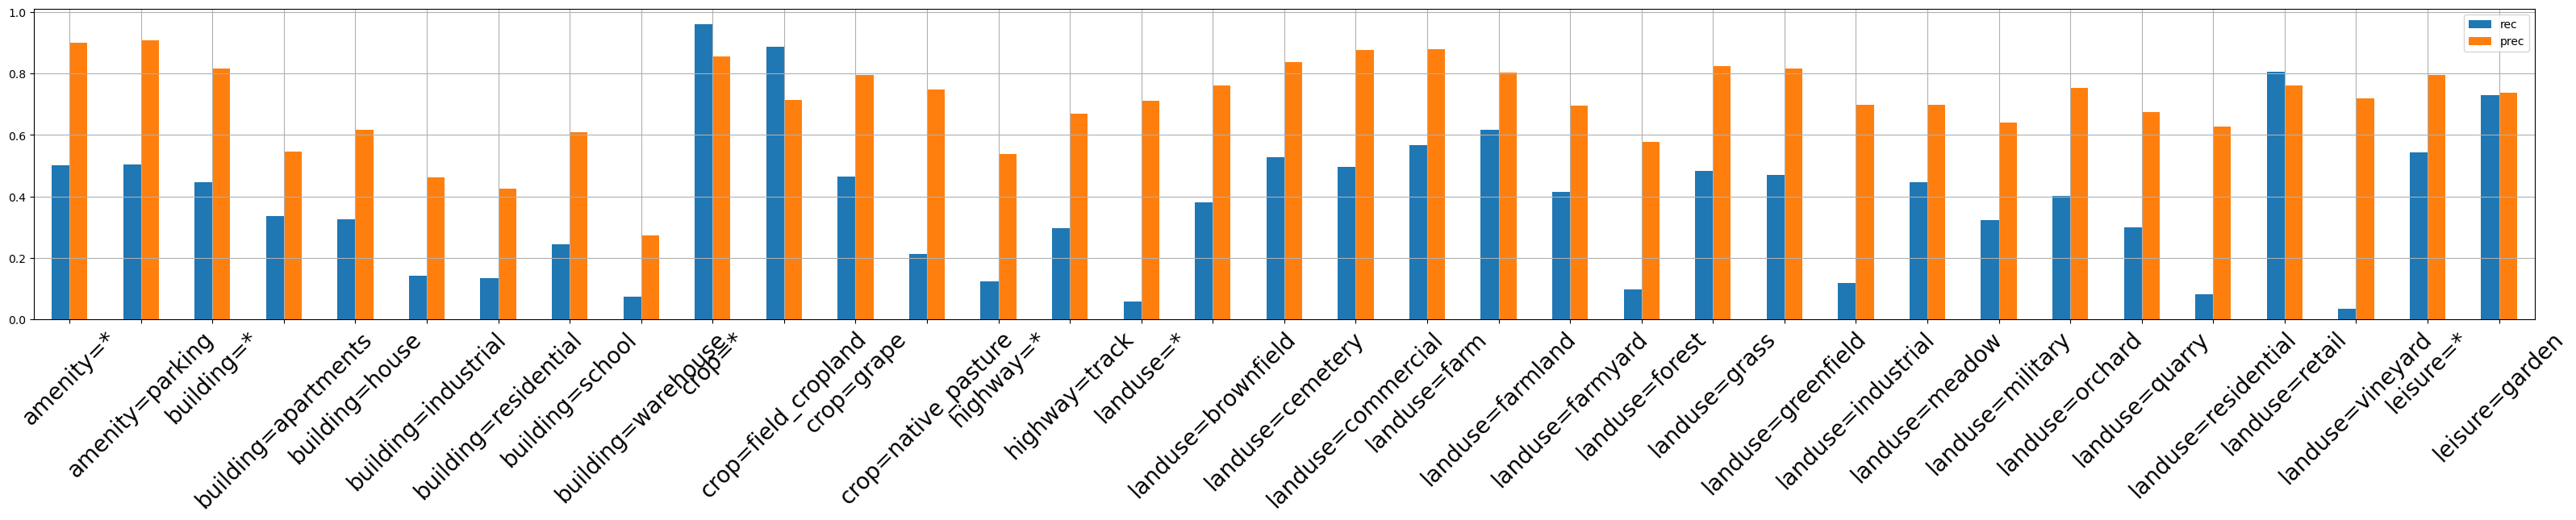

In [133]:
ax = pd.DataFrame(R[5], columns=['rec', 'prec']).plot(kind='bar', figsize=(40,5), grid=True);
ax.set_xticklabels(labels=(name_dict[i] for i in range(len(classes_retain))), rotation=45, fontsize=20);

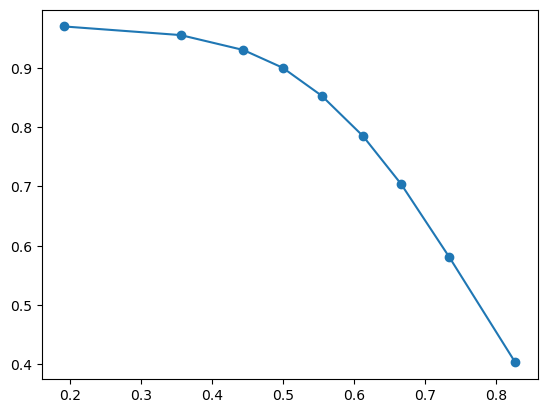

In [158]:
plt.plot(*R[:, 0, :].T, 'o-');

<Figure size 640x480 with 0 Axes>

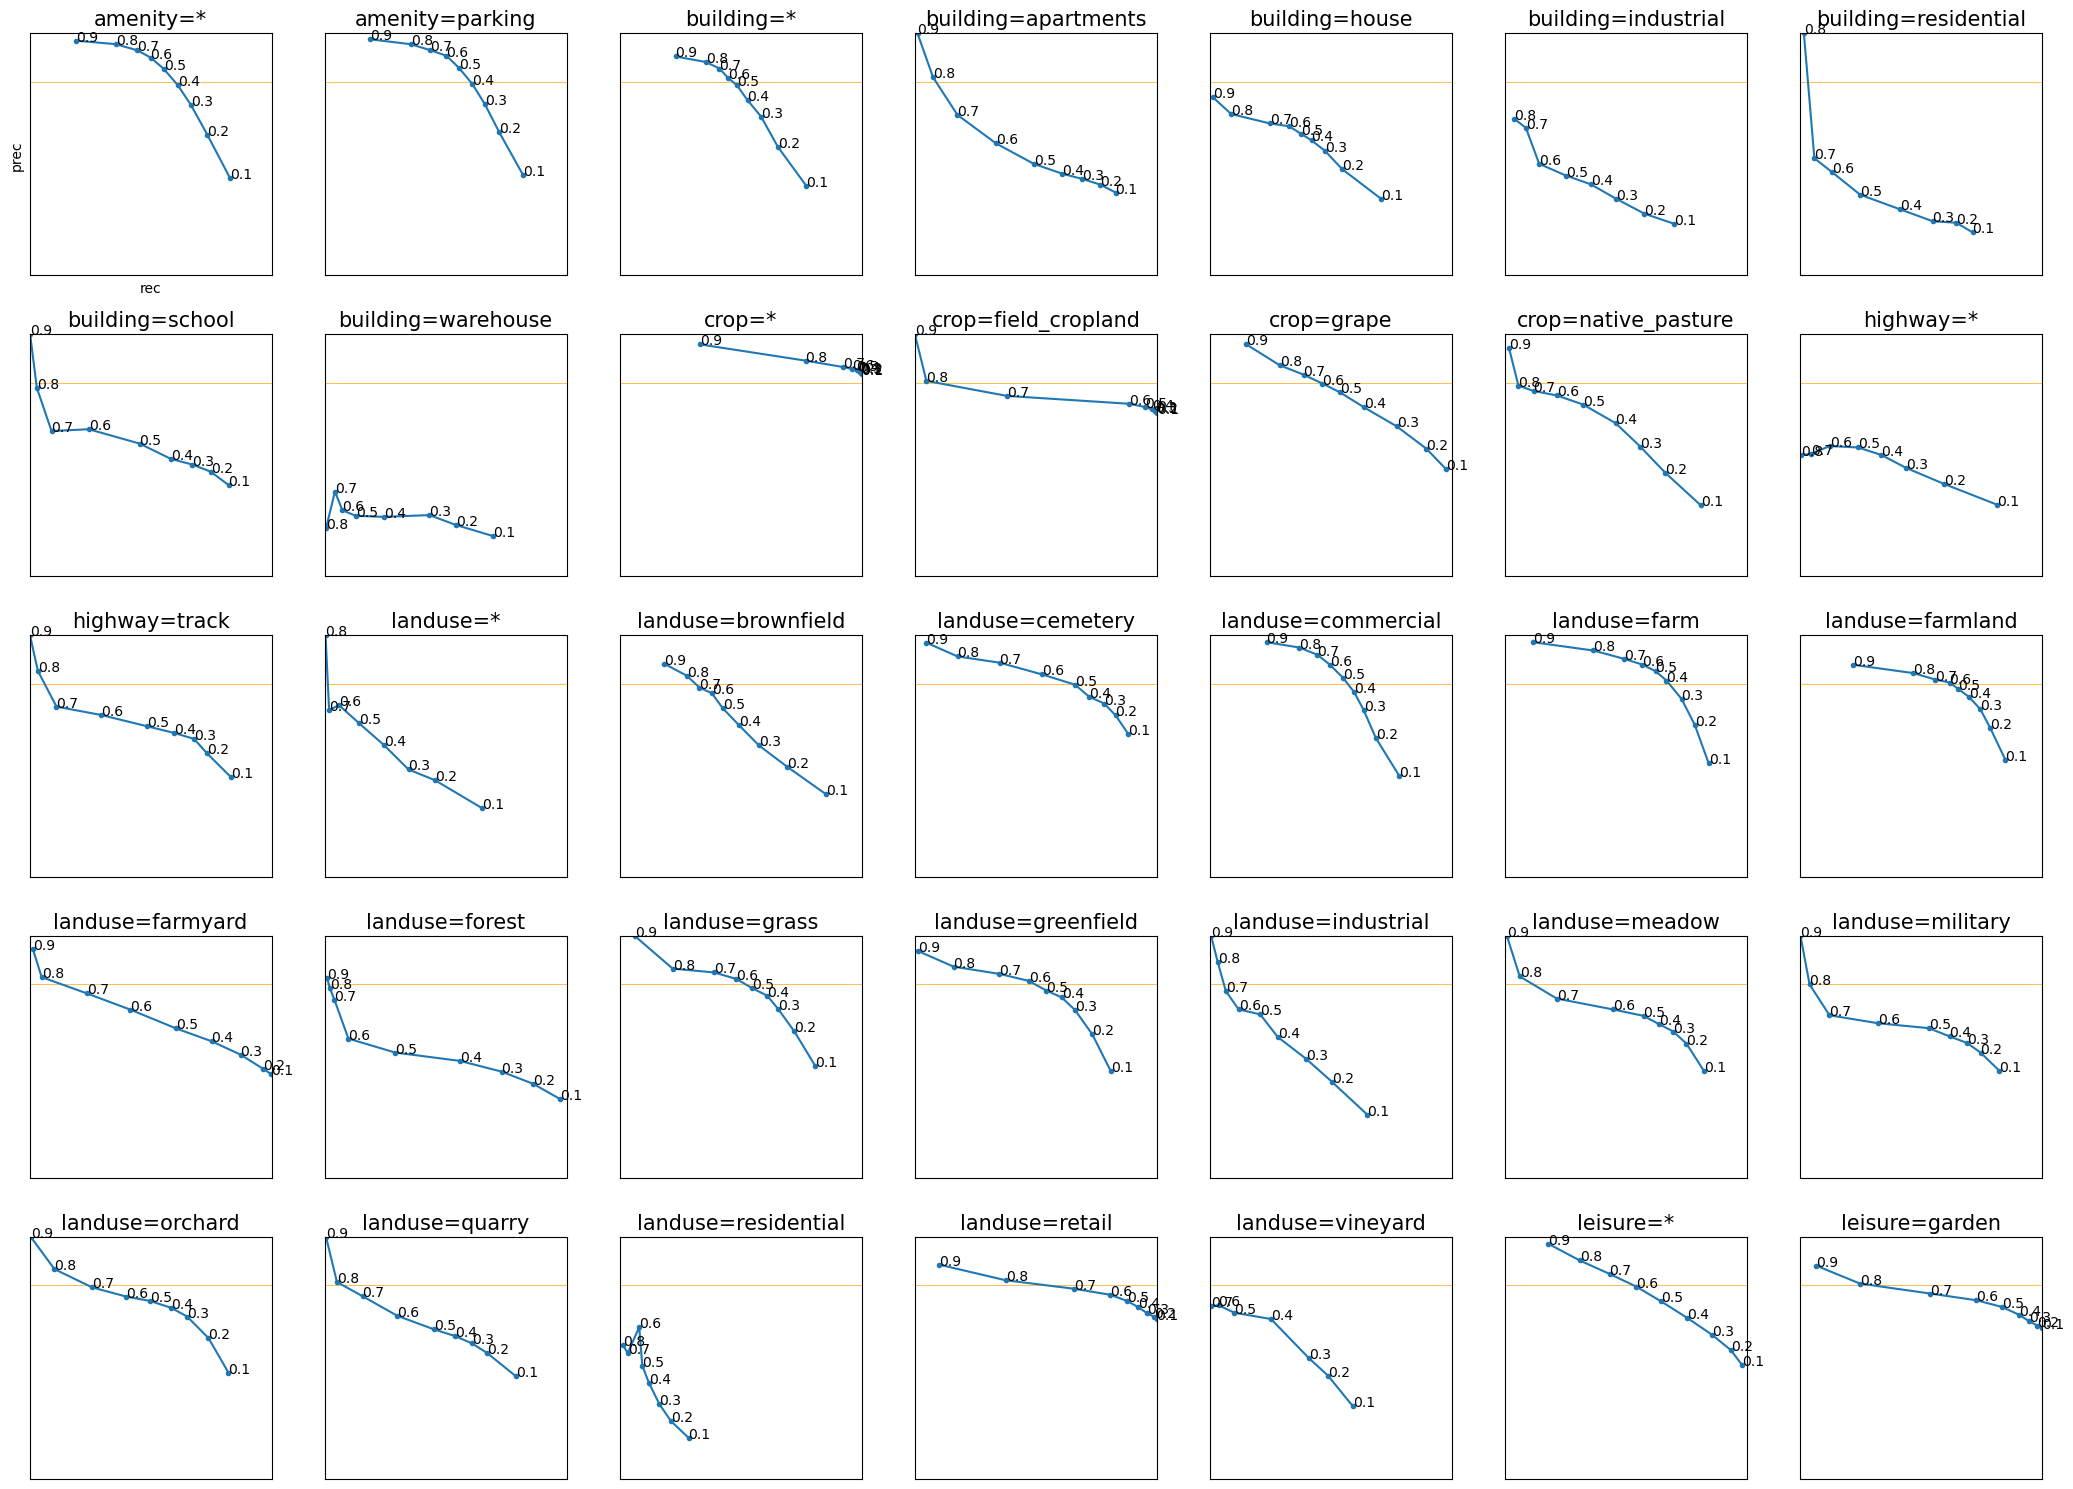

In [268]:
fig = plt.figure();
for ax, c in subplots(len(classes_retain), n_cols=len(classes_retain)//5, usizex=3, usizey=3):
    ax.plot([0,1], [.8,.8], lw=.5, c='orange');
    ax.set_title(name_dict[c], fontsize=15);
    ax.set_xlim(0, 1); ax.set_ylim(0, 1);
    # if c != 0:
    ax.set_yticks([]); ax.set_xticks([]);
    ax.set_aspect('equal')
    if c == 0:
        ax.set_xlabel('rec', fontsize=10); ax.set_ylabel('prec', fontsize=10);
    ax.plot(*R[:, c, :].T, marker='o', ls='-', markersize=3);
    for i, thres in enumerate(np.linspace(0.1, 1, 10)):
        if None not in R[i, c, :] and np.isfinite(list(R[i, c, :])).all():
            ax.text(*R[i, c, :], f"{thres:.1f}", fontsize=10)
plt.tight_layout();

#### Which threshold results in precision > 80%

From the above, we can remove the following:
- `building=house, industrial, warehouse`
- `highway=*`
- `landuse=*, residential, vineyard`

Also the following because of redundancy:
- `amenity=*`
<!-- - `building=warehouse`, 8 -->
<!-- - `highway=*`, 13 -->
<!-- - `landuse=*`, 15 -->
<!-- - `landuse=residential`, 30 -->

In [62]:
e = lambda: np.random.rand()*1e-2

<Figure size 500x500 with 0 Axes>

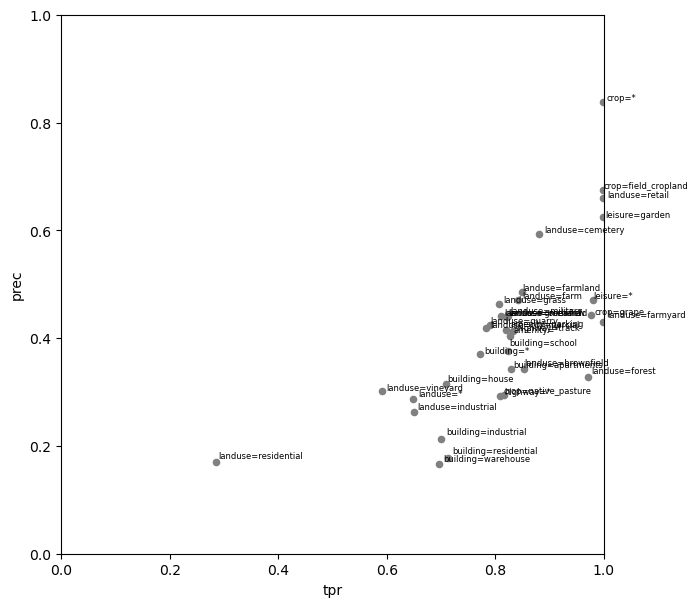

In [65]:
fig = plt.figure(figsize=(5, 5));

k = 0
ax = R[k][['tpr', 'prec']].plot(kind='scatter', x='tpr', y='prec', c='gray', figsize=(7, 7))
ax.set_xlim(0,1); ax.set_ylim(0,1);

for i in range(len(np.array(R[k].tpr))):
    if not np.isnan(np.array(R[k].prec)[i]):
        ax.text(x=np.array(R[k].tpr)[i] + e(), y=np.array(R[k].prec)[i] + e(), s=name_dict[list(R[k].index)[i]], size=6)